In [1]:
%matplotlib inline

Integrating Custom Detection Model to Vortex
=================================================
This tutorial shows how to create custom detection model and integrate to `vortex`.
In this particular case, we will integrate **`DE:TR` (Detection Transformer)**, and
constrained to inference only.

In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision as vision
import torchvision.transforms as T
from torchvision.models import resnet50

torch.set_grad_enabled(False)

import cv2
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import vortex.development
import vortex.development.networks as networks
import vortex.development.networks.modules as vortex_modules
import vortex.development.exporter.utils.onnx.graph_ops as graph_ops

Pipeline = vortex.development.core.pipelines.PytorchPredictionPipeline
ExportPipeline = vortex.development.core.pipelines.GraphExportPipeline
ONNXPipeline = vortex.development.core.pipelines.IRPredictionPipeline
TorchScriptPipeline = vortex.development.core.pipelines.IRPredictionPipeline
np.set_printoptions(precision=2, suppress=True)

1. Model Architecture
---------------------
DETR Demo taken from [facebookresearch/detr](https://github.com/facebookresearch/detr)'s 
[google colab demo](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb).
Modified for `vortex` compatibility by adding `task` and `output_format` atrributes to
our model.

`output_format` is a nested `dict`, with signature of `Dict[str,dict]`,
with inner `dict` with signature of `Dict[str,Union[list,int]]`.  The inner
dictionary is a mapping from output name to arguments that will be used for tensor slicing.
The tensor slicing operation will be performed using `np.take`, `Onnx.Gather`, or
`torch.index_select`; the arguments' naming use numpy's take, that is `indices` and `axis`;
check numpy, onnx, or torch docs for more details.

For detection models, we need `class_label`, `class_confidence`, and `bounding_box`.
`output_format` will be used to slice single sample (image). In case of detection models,
there might be multiple objects for single sample, so the result from single sample is 
2D tensor. Hence, we take the tensor's values at `axis=1`.

Note that in the official DETR demo, the model's postprocess returned the full probability tensor
but in our case, we want to take only 1D tensor, so we set `indices` of `class_label` to `[4]`
and `class_confidence` to `[5]`, these values should be corresponding to our postprocess module's output.

In [3]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

        # attributes for vortex
        self.task = "detection"
        self.output_format = dict(
            class_label=dict(
                indices=[4], axis=1
            ),
            class_confidence=dict(
                indices=[5], axis=1
            ),
            bounding_box=dict(
                indices=[0,1,2,3], axis=1
            )
        )

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        # workaround to handle batched input
        src = pos + 0.1 * h.flatten(2).permute(2, 0, 1)
        tgt = self.query_pos.unsqueeze(1).repeat(1, src.size(1), 1)
        h = self.transformer(src,tgt).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

helper function to get pretrained DETR on COCO

In [4]:
def coco_detr():
    detr = DETRdemo(num_classes=91)
    state_dict = torch.hub.load_state_dict_from_url(
        url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
        map_location='cpu', check_hash=True)
    detr.load_state_dict(state_dict)
    detr.eval()
    return detr

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

2. Create PostProcess module
----------------------------

Next, let's define our post-process module. As the name suggests, this module
will be called after model inference. In this module we will format the model's
output tensor to our format, as well as, decoding the model's output tensor to
perform score thresholding, and bounding box conversion.

Our postprocess module will take two input, the network output 
and additional `score_threshold` as input. By default, the network output will
be forwarded to postprocess. For our `score_threshold`, we need to tell vortex
that our postprocess requires additional input, by adding attribute `additional_inputs`
to our postprocess. The signature is `Tuple[Tuple[str,Tuple[int,...]],...]`, with
first elements of the sequences are the input names and the seconds are the input shapes.
By doing this, we can change the value even after export to TorchScript or ONNX.

Also note that we introduce workaround for `torch==1.4`, `onnx==1.6` and `onnxruntime==1.2`.
Onnx operator `Greater` can't have `tensor(bool)` as input, but torch onnx exporter
won't complain. `squeeze` and `nonzero` also inserted to match appropriate dimension
and type for `index_select` (for slicing).

In [5]:
class DETRPostProcess(nn.Module):
    def __init__(self):
        super().__init__()
        # tell vortex that our postprocess has additional input
        # that is score threshold with shape of torch.Size([1])
        self.additional_inputs = (
            ('score_threshold', (1,)),
        )

    def _forward(self, input: torch.Tensor, score_threshold: torch.Tensor) -> torch.Tensor:
        # keep only predictions > score_threshold
        probas = input['pred_logits'].softmax(-1)[:, :-1]
        
        # workaround for onnx inference (torch 1.4, onnx 1.6, onnxruntime 1.2)
        # op `Greater` can't have tensor(bool) as input
        values, indices = probas.max(-1, keepdim=True)
        keep = torch.gt(values, score_threshold).squeeze(-1).nonzero().squeeze(-1)

        # convert to xyxy
        out_bbox = input['pred_boxes'].index_select(0,keep)
        out_bbox = box_cxcywh_to_xyxy(out_bbox)

        # take confidence and classes and match bbox dim
        # probas = probas[keep]
        probas = probas.index_select(0, keep)
        conf_label, cls_label = probas.max(dim=1, keepdim=False)
        conf_label.unsqueeze_(-1)
        cls_label.unsqueeze_(-1)

        # concat input
        output = torch.cat((out_bbox,cls_label.float(),conf_label),-1)
        return output
    
    def forward(self, input: torch.Tensor, score_threshold: torch.Tensor) -> torch.Tensor:
        num_batch = input['pred_logits'].size(0)
        results = []
        # workaround to handle batched input,
        # `num_batch` will be static after export
        for i in range(num_batch):
            pred_input = {key: value[i] for key, value in input.items()}
            result = self._forward(pred_input, score_threshold)
            results.append(result)
        return tuple(results)

3. Registering our model to vortex
----------------------------------

After defining necessary components, we need to define *builder* function
that will create instances of necessary components, then we register it to vortex
by decorating the function and providing the model name.

This function serves as entry point and customization point for our loss, model,
and post-process, and optionally preprocess and dataset collater. For example, you
need to reuse parameter from networks to postprocess, you can do it here.

The required components are `preprocess`, `network`, and `postprocess`.
For training, we need additional components, `loss` and optional `collate_fn`.
For preprocess, it is recommended to use modules from `vortex_modules.preprocess` to 
make sure it is exportable.

Here, we will also perform some *hack* to keep pretrained weights. And note that since
we will implements inference only (for now), we will just reject training stage.

In [6]:
@networks.models.register_model(model_name='detr')
def create_model_components(
    model_name, preprocess_args,
    network_args, loss_args,
    postprocess_args, stage) -> dict:

    pretrained = network_args.pop('pretrained',False)
    num_classes = network_args.pop('num_classes',91)

    if pretrained:

        # make sure our config match available pretrained
        assert network_args.get('nheads',8)==8 and          \
            network_args.get('hidden_dim',256)==256 and     \
            network_args.get('num_encoder_layers',6)==6 and \
            network_args.get('num_decoder_layers',6)==6,    \
            "pretrained not available"
        
        # start from pretrained
        model = coco_detr()

        # looking at the implementation, we restore number of class if necessary
        if num_classes != 91:
            model.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        
        # override preprocess to match with pretrained preprocess
        preprocess_args = {
                'input_size': 800,
                'input_normalization': {
                'mean': [0.485, 0.456, 0.406],
                'std': [0.229, 0.224, 0.225],
                'scaler': 255,
            }
        }
    else:
        model = DETRdemo(**network_args)
    
    # using vortex' preprocess module
    normalizer = 'normalizer'
    if pretrained:
        normalizer = 'flip_normalizer' # rgb2bgr
    
    preprocess = vortex_modules.preprocess.get_preprocess(
        normalizer, **preprocess_args
    )
    
    # instantiate our DETR postprocess
    postprocess = DETRPostProcess(**postprocess_args)

    # wrap-up core components
    components = dict(
        preprocess=preprocess,
        network=model,
        postprocess=postprocess,
    )

    # current implemenetation doesn't support training
    if stage == 'train':
        raise NotImplementedError("current implementation doesn't support training yet")

    return components

4. Integration with vortex CLI
------------------------------

We'll provide entry-point for our experiments to get more vortex' features
in a *configuratble* way. Doing this is as simple as calling `vortex_cli`'s
main function and we are all set. To separate this from demo program, let's
wrap it on `cli()` and create another python scripts calling this `cli()` as
our entry-point (see `cli.py`)

In [7]:
def cli():
    vortex.development.vortex_cli.main()

5. Demo program
---------------

Prepare some files

In [8]:
run_demo = False
if __name__ == '__main__':
    run_demo = True

from pathlib import Path

def download_image(url: str, filename: str):
    path = Path(filename)
    try:
        Image.open(path)
    except:
        with path.open('wb+') as f:
            f.write(requests.get(url).content)
    return filename

images = [
    dict(
        url='http://images.cocodataset.org/val2017/000000039769.jpg',
        filename='000000039769.jpg'
    ),
    dict(
        url='http://farm7.staticflickr.com/6153/6162098289_512fc331dc_z.jpg',
        filename='6162098289_512fc331dc_z.jpg'
    ),
    dict(
        url='http://farm9.staticflickr.com/8539/8640225449_73c750f686_z.jpg',
        filename='8640225449_73c750f686_z.jpg'
    ),
    dict(
        url='http://farm5.staticflickr.com/4008/4295843111_bee8c2f586_z.jpg',
        filename='4295843111_bee8c2f586_z.jpg'
    )
]

downloaded_images = list(map(lambda args: download_image(**args), images))

Create helper function for detr demo. You can run this demo using 
`examples/custom_models/detr/detr.py` or `examples/custom_models/detr/detr.ipynb`.

In [9]:
def detr_demo():
    def rescale_bboxes(out_bbox, size):
        img_w, img_h = size
        b = box_cxcywh_to_xyxy(out_bbox)
        b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
        return b

    def detect(im, model, transform):
        # mean-std normalize the input image (batch-size: 1)
        img = transform(im).unsqueeze(0)

        # propagate through the model
        outputs = model(img)

        # keep only predictions with 0.7+ confidence
        probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
        keep = probas.max(-1).values > 0.7

        # convert boxes from [0; 1] to image scales
        bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
        return probas[keep], bboxes_scaled

    def plot_results(pil_img, prob, boxes):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()
    # COCO classes
    CLASSES = [
        'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
        'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
        'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
        'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
        'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
        'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
        'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
        'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
        'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
        'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
        'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
        'toothbrush'
    ]
    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    # standard PyTorch mean-std input image normalization
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    detr = coco_detr()

    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    im = Image.open(requests.get(url, stream=True).raw)

    scores, boxes = detect(im, detr, transform)

    plot_results(im, scores, boxes)

Create helper function for detr demo using `vortex`

In [10]:
def load_config(cfg='detr.yml'):
    import yaml, os, pathlib, easydict
    
    with open(cfg) as f:
        config = easydict.EasyDict(yaml.load(f))
    
    # prepare path
    TORCH_HOME = os.getenv('TORCH_HOME', os.environ['HOME'] + '/.cache/torch/')
    weights_file = pathlib.Path(TORCH_HOME)
    weights_file = weights_file / 'checkpoints' / 'detr_demo-da2a99e9.pth'

    return dict(
        config=config,
        weights_file=weights_file
    )

def visualize(results):
    for visualization, prediction in zip(results.visualization, results.prediction) :
        # visualization
        plt.figure()
        plt.imshow(cv2.cvtColor(visualization,cv2.COLOR_BGR2RGB))

        # print results
        print('prediction results:')
        print(prediction)

def vortex_demo(cfg='detr.yml',test_images='000000039769.jpg', score_threshold=0.7):
    """
    helper function to run torch inference on vortex
    """

    cfg = load_config(cfg)
    config = cfg['config']
    weights_file = cfg['weights_file']

    # create predictor
    predictor = Pipeline(config, weights_file, 'cuda' if torch.cuda.is_available() else 'cpu')

    # run prediction
    test_images = test_images
    if isinstance(test_images, str):
        test_images = [test_images]
    run_args = dict(
        dump_visual=True, visualize=True, 
        score_threshold=score_threshold
    )
    results = predictor.run(test_images, **run_args)

    visualize(results)

def vortex_export(cfg='detr.yml', test_images='000000039769.jpg'):
    """
    helper function to export detr to ONNX & TorchScript
    """
    cfg = load_config(cfg)
    config = cfg['config']
    weights_file = cfg['weights_file']

    exporter = ExportPipeline(config, weights=weights_file)
    result = exporter.run(example_input=test_images)

def torchscript_demo(model=None, runtime='cpu', test_images='000000039769.jpg', score_threshold=0.7):
    """
    helper function to run torchscript inference on vortex
    """

    if model is None:
        model = 'experiments/outputs/detr/detr-bs4.pt'

    # create predictor
    predictor = TorchScriptPipeline(model, runtime=runtime)

    # run prediction
    # run prediction
    test_images = test_images
    if isinstance(test_images, str):
        test_images = [test_images]
    run_args = dict(
        dump_visual=True, visualize=True, 
        score_threshold=score_threshold
    )
    results = predictor.run(test_images, **run_args)

    visualize(results)

def onnx_demo(model=None, runtime='cpu', test_images='000000039769.jpg', score_threshold=0.7):
    """
    helper function to run onnx inference on vortex
    """

    if model is None:
        model = 'experiments/outputs/detr/detr.onnx'

    # create predictor
    predictor = ONNXPipeline(model, runtime=runtime)

    # run prediction
    test_images = test_images
    if isinstance(test_images, str):
        test_images = [test_images]
    run_args = dict(
        dump_visual=True, visualize=True, 
        score_threshold=score_threshold,
    )
    results = predictor.run(test_images, **run_args)

    visualize(results)

`DE:TR` Demo using original demo code

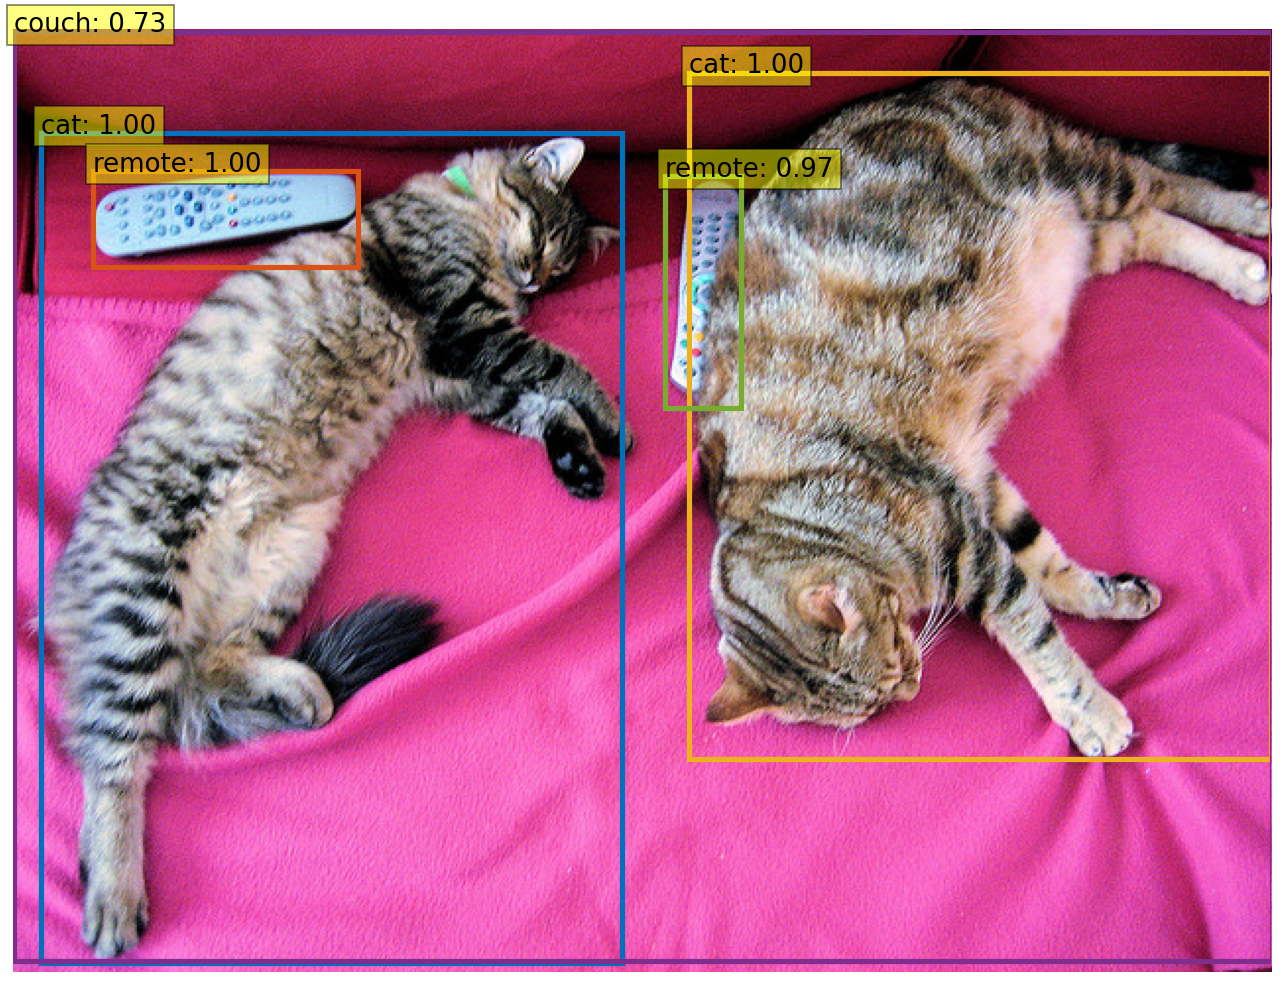

In [11]:
detr_demo() if run_demo else 'skip detr demo'

`DE:TR` Demo using `vortex`

prediction saved to prediction_000000039769.jpg, prediction_6162098289_512fc331dc_z.jpg, prediction_8640225449_73c750f686_z.jpg, prediction_4295843111_bee8c2f586_z.jpg
prediction results:
{'bounding_box': array([[ 14.57,  52.98, 311.71, 474.02],
       [ 40.46,  74.02, 176.14, 118.82],
       [339.85,  22.38, 639.94, 371.58],
       [  0.23,   0.74, 640.2 , 475.43],
       [334.22,  76.12, 369.21, 192.81]], dtype=float32), 'class_confidence': array([[1.  ],
       [1.  ],
       [1.  ],
       [0.78],
       [0.96]], dtype=float32), 'class_label': array([[17.],
       [75.],
       [17.],
       [63.],
       [75.]], dtype=float32)}
prediction results:
{'bounding_box': array([[254.  , 259.54, 304.49, 480.39],
       [106.35,  97.41, 409.87, 479.7 ]], dtype=float32), 'class_confidence': array([[1.],
       [1.]], dtype=float32), 'class_label': array([[32.],
       [ 1.]], dtype=float32)}
prediction results:
{'bounding_box': array([[ 38.74,  52.47, 160.95, 592.47],
       [153.65, 206.17

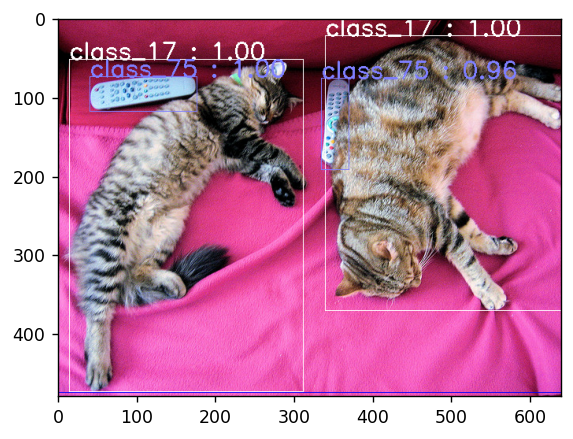

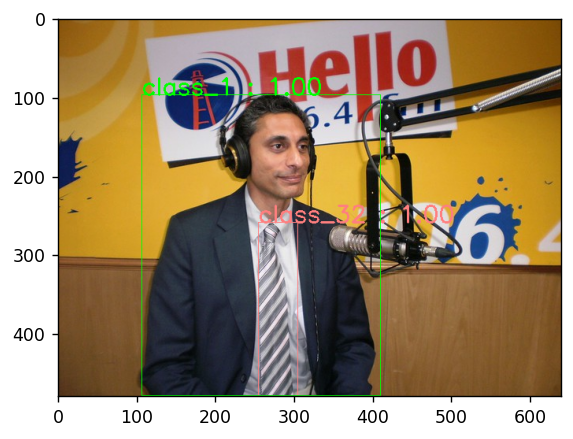

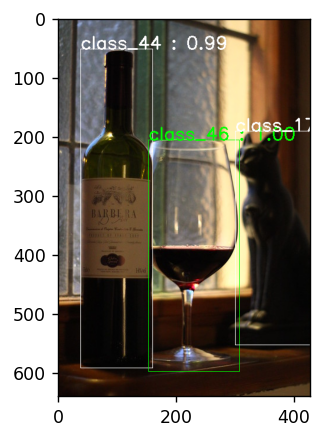

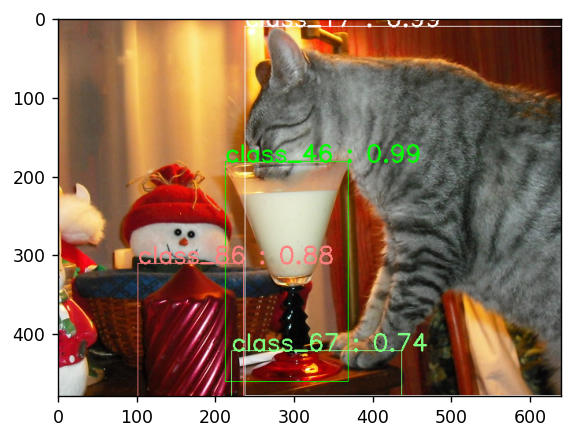

In [12]:
vortex_demo(test_images=downloaded_images) if run_demo else 'skip detr demo'

Export `DE:TR` to `ONNX` and `TorchScript` using vortex

In [13]:
vortex_export() if run_demo else 'skip detr export'

embedding output_format to model : torch-jit-export
embedding class_names to model : torch-jit-export


model is exported to: experiments/outputs/detr/detr.onnx, experiments/outputs/detr/detr.pt, experiments/outputs/detr/detr-bs4.pt


TorchScript Inference using exported graph

Runtime cpu <TorchScriptRuntimeCpu>: available
Runtime cuda <TorchScriptRuntimeCuda>: available
prediction saved to torchscript_ir_prediction_000000039769.jpg, torchscript_ir_prediction_6162098289_512fc331dc_z.jpg, torchscript_ir_prediction_8640225449_73c750f686_z.jpg, torchscript_ir_prediction_4295843111_bee8c2f586_z.jpg
prediction results:
{'bounding_box': array([[ 14.57,  52.98, 311.71, 474.02],
       [ 40.46,  74.02, 176.14, 118.82],
       [339.85,  22.38, 639.94, 371.58],
       [  0.23,   0.74, 640.2 , 475.43],
       [334.22,  76.12, 369.21, 192.81]], dtype=float32), 'class_confidence': array([[1.  ],
       [1.  ],
       [1.  ],
       [0.78],
       [0.96]], dtype=float32), 'class_label': array([[17.],
       [75.],
       [17.],
       [63.],
       [75.]], dtype=float32)}
prediction results:
{'bounding_box': array([[254.  , 259.54, 304.49, 480.39],
       [106.35,  97.41, 409.87, 479.7 ]], dtype=float32), 'class_confidence': array([[1.],
       [1.]], dtype=float32), 'cla

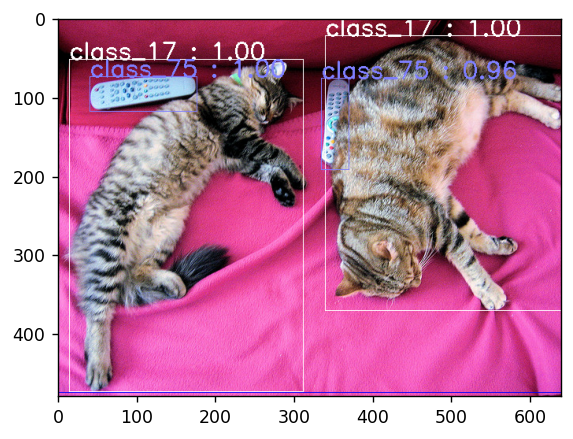

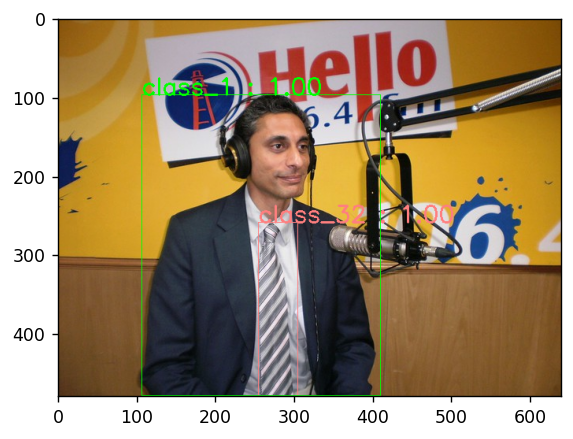

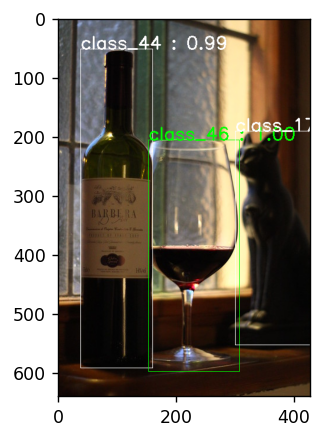

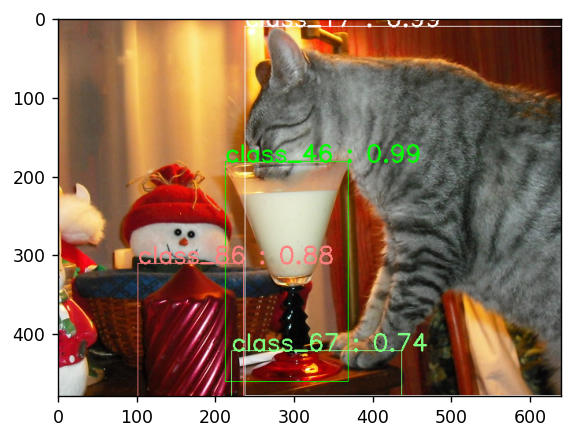

In [14]:
torchscript_demo(test_images=downloaded_images) if run_demo else 'skip torchscript demo'

ONNX Inference using exported graph

In [15]:
# skip for now
# onnx_demo() if run_demo else 'skip onnx demo'